# Lecture 03: Linear models (regression)

Objectives:
1. Reminder about regularized linear regression.
2. Use of different distributions for noise.
3. Numerical optimization for maximum likelihood estimation.

In [1]:
import numpy as np, matplotlib.pyplot as plt
import polars as pl
from sklearn.linear_model import Ridge
from scipy.special import beta

# Load data

Loading and simple cleanup.

In [2]:
df = (
    pl.read_csv("https://github.com/Michael-tehc/MachineLearning-MSU/raw/refs/heads/main/data/Housing.csv")
    .with_columns(
        pl.Series('dprice', list(np.random.binomial(1, 0.05, 545) * 2e7))
    )
    .with_columns(
        price=pl.col('price') + pl.col('dprice')
    )
)
df

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,dprice
f64,i64,i64,i64,i64,str,str,str,str,str,i64,str,str,f64
1.33e7,7420,4,2,3,"""yes""","""no""","""no""","""no""","""yes""",2,"""yes""","""furnished""",0.0
1.225e7,8960,4,4,4,"""yes""","""no""","""no""","""no""","""yes""",3,"""no""","""furnished""",0.0
1.225e7,9960,3,2,2,"""yes""","""no""","""yes""","""no""","""no""",2,"""yes""","""semi-furnished""",0.0
1.2215e7,7500,4,2,2,"""yes""","""no""","""yes""","""no""","""yes""",3,"""yes""","""furnished""",0.0
1.141e7,7420,4,1,2,"""yes""","""yes""","""yes""","""no""","""yes""",2,"""no""","""furnished""",0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.82e6,3000,2,1,1,"""yes""","""no""","""yes""","""no""","""no""",2,"""no""","""unfurnished""",0.0
1.76715e6,2400,3,1,1,"""no""","""no""","""no""","""no""","""no""",0,"""no""","""semi-furnished""",0.0
1.75e6,3620,2,1,1,"""yes""","""no""","""no""","""no""","""no""",0,"""no""","""unfurnished""",0.0


In [3]:
# Transform `yes/no` values to 1/0
df_clean = df.with_columns(
    pl.col('price').log(),
    pl.col('area').log(),
    pl.col(
        "mainroad guestroom basement hotwaterheating airconditioning prefarea".split()
    ).replace_strict(['yes', 'no'], [True, False])
)
df_clean

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,dprice
f64,f64,i64,i64,i64,bool,bool,bool,bool,bool,i64,bool,str,f64
16.403275,8.911934,4,2,3,true,false,false,false,true,2,true,"""furnished""",0.0
16.321036,9.100526,4,4,4,true,false,false,false,true,3,false,"""furnished""",0.0
16.321036,9.206332,3,2,2,true,false,true,false,false,2,true,"""semi-furnished""",0.0
16.318175,8.922658,4,2,2,true,false,true,false,true,3,true,"""furnished""",0.0
16.250001,8.911934,4,1,2,true,true,true,false,true,2,false,"""furnished""",0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
14.414347,8.006368,2,1,1,true,false,true,false,false,2,false,"""unfurnished""",0.0
14.384879,7.783224,3,1,1,false,false,false,false,false,0,false,"""semi-furnished""",0.0
14.375126,8.194229,2,1,1,true,false,false,false,false,0,false,"""unfurnished""",0.0


In [4]:
FEATURE_NAMES = ['area', 'bedrooms', 'bathrooms', 'mainroad', 'basement']
X = df_clean.select(FEATURE_NAMES).to_numpy()
y = df_clean['price'].to_numpy()
X.shape, y.shape

((545, 5), (545,))

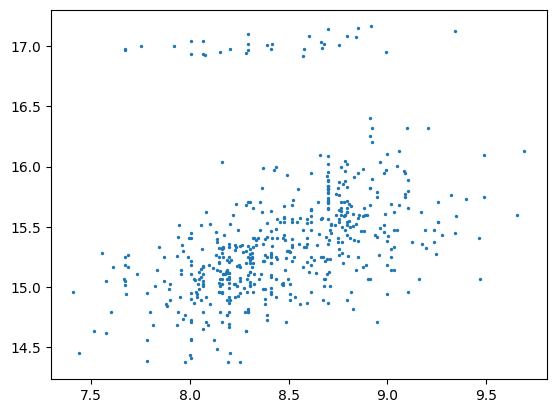

In [5]:
plt.scatter(X[:, 0], y, s=2);

# Simple linear model: Gaussian noise + Ridge regularization

Semi-Bayesian formulation:
$$
\begin{aligned}
w &\sim \mathcal N\left( 0, \frac{1}{\lambda} I \right)\\
y_n &= b + x_n^\top w + \sigma \varepsilon_n, \quad \varepsilon_n \sim \mathcal N(0,1)
\end{aligned}
$$

A "truly Bayesian" formulation should have priors for $b \in \mathbb R$ and $\sigma > 0$.

Optimization problem:
$$
\begin{aligned}
\hat{b}, \hat w, \hat\sigma
&= \arg\min_{b,w,\sigma} \left[ -\sum_{n=1}^N \left(
 -\frac12 \ln(2\pi)
 -\ln \sigma - \frac12 \frac{(y_n - b - w^\top x_n)^2}{\sigma^2}
\right) + \lambda \frac12 \lVert w \rVert^2
\right]\\
&= \arg\min_{b,w,\sigma} \left[
 N\ln\sigma + \frac12 \frac{\lVert y - \mathbb 1 b - Xw \rVert^2}{\sigma^2} + \lambda \frac12 \lVert w \rVert^2
\right]
\end{aligned}
$$

Take derivatives:
$$
\begin{aligned}
\partial b &=-\sum_n (y_n - \mathbb 1 b - x_n^\top w) = 0\\
\nabla w &= -X^\top (y - \mathbb 1 b - Xw) + (\lambda I) w = 0\\
\partial \sigma &= \frac{N}{\sigma} - \frac{\lVert y - \mathbb 1 b - Xw \rVert^2}{\sigma^3} = 0
\end{aligned}
$$

## 1. Solve for $(b,w)$
Note that since $\sigma$ is the same for all observations, $(b,w)$ don't depend on $\sigma$! Otherwise we'd get _weighted_ linear regression.

Arrange into system of linear equations:
$$
\begin{aligned}
N b + \sum_n x_n^\top w &= \sum_n y_n\\
X^\top \mathbb 1 b + (X^\top X + \lambda I) w &= X^\top y
\end{aligned}
\implies
\underbrace{
\begin{bmatrix}
N & \sum_n x_n^\top\\
X^\top \mathbb 1 & X^\top X + \lambda I
\end{bmatrix}}_A
\begin{bmatrix}
b\\ w
\end{bmatrix}
= \begin{bmatrix}
\sum_n y_n\\
X^\top y
\end{bmatrix}
$$
Shape of the matrix $A$:
$$
\begin{aligned}
N &\in \mathbb R^{1 \times 1}\\
X^\top \mathbb 1 &\in \mathbb R^{F \times 1}\\
\sum_n x_n^\top &\in \mathbb R^{1 \times F}\\
X^\top X + \lambda I &\in \mathbb R^{F \times F}
\end{aligned}
$$
Thus, $A \in \mathbb R^{(F+1) \times (F+1)}$.

Solve this with `numpy.linalg.solve`, get estimates $(\hat b, \hat w)$.

## 2. Now that $(\hat b, \hat w)$ are known, solve for $\sigma$
$$
\hat\sigma = \sqrt{
 \frac1N \lVert y - \mathbb 1 \hat b - X \hat w \rVert^2
}
$$

In [6]:
def loglik_Gauss(params, X, y):
    N, F = X.shape
    b, w, sigma = params[0], params[1:F+1], params[F+1]
    residuals = (y - b - X @ w) / sigma
    return (
        -0.5 * np.log(2 * np.pi) - np.log(sigma) - 0.5 * residuals**2
    ).sum()

In [7]:
def solve_Gauss_ridge(X, y, lmb: float):
    N, F = X.shape
    assert y.shape == (N, )

    XT1 = X.sum(axis=0)
    # Matrix for system of linear equations
    A = np.empty((F+1, F+1))
    A[0, 0] = N
    A[1:, 0] = XT1
    A[0, 1:] = XT1
    A[1:, 1:] = X.T @ X + lmb * np.eye(F, F)
    # Vector for system of linear equations
    c = np.hstack([
        np.atleast_1d(y.sum()),
        X.T @ y
    ])

    # 1. Solve A.dot(bw) = c for (b, w)
    bw = np.linalg.solve(A, c)
    b, w = bw[0], bw[1:]
    # 2. Solve for sigma
    sigma = np.sqrt(
        np.linalg.norm(y - b - X @ w)**2 / N
    )
    return b, w, sigma

In [8]:
class RidgeGauss:
    def __init__(self, lmb: float, feature_names: list[str]):
        assert lmb >= 0
        self.lmb = lmb
        self.feature_names = list(feature_names)

    def __repr__(self):
        df = pl.DataFrame({
            'name': ['bias', *self.feature_names, 'scale'],
            'value': [self.intercept_, *self.coef_, self.scale_]
        })
        with pl.Config(tbl_hide_column_data_types=True):
            return (
                f"RidgeGauss({self.lmb}) (AIC={self.aic_:.3f}):\n"
                f"{df}"
            )

    def fit(self, X, y):
        self.intercept_, self.coef_, self.scale_ = solve_Gauss_ridge(X, y, self.lmb)
        NPARAMS = 1 + len(self.coef_) + 1
        self.noise_ = (y - self.intercept_ - X @ self.coef_) / self.scale_
        self.aic_ = -2 * loglik_Gauss(
            [self.intercept_, *self.coef_, self.scale_],
            X, y
        ) + 2 * NPARAMS
        return self

In [9]:
RidgeGauss(0.0, FEATURE_NAMES).fit(X, y)

RidgeGauss(0.0) (AIC=760.123):
shape: (7, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 11.750097 │
│ area      ┆ 0.356645  │
│ bedrooms  ┆ 0.060223  │
│ bathrooms ┆ 0.245919  │
│ mainroad  ┆ 0.138482  │
│ basement  ┆ 0.075322  │
│ scale     ┆ 0.479783  │
└───────────┴───────────┘

In [10]:
(
    Ridge(0.0).fit(X, y).intercept_,
    Ridge(0.0).fit(X, y).coef_
)

(np.float64(11.750096850195082),
 array([0.35664499, 0.06022283, 0.2459192 , 0.13848222, 0.07532219]))

In [11]:
RidgeGauss(100.0, FEATURE_NAMES).fit(X, y)

RidgeGauss(100.0) (AIC=781.678):
shape: (7, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 13.359822 │
│ area      ┆ 0.181928  │
│ bedrooms  ┆ 0.073576  │
│ bathrooms ┆ 0.156623  │
│ mainroad  ┆ 0.084371  │
│ basement  ┆ 0.050362  │
│ scale     ┆ 0.489365  │
└───────────┴───────────┘

In [12]:
Ridge(100.0).fit(X, y).intercept_ - RidgeGauss(100.0, FEATURE_NAMES).fit(X, y).intercept_

np.float64(-1.1812772982011666e-12)

In [13]:
def how_regularization_affects_Gauss(X, y, feat_names: list[str], lambdas: np.ndarray):
    data = {
        'lambdas': []
    } | {
        name: [] for name in feat_names
    }
    for lmb in lambdas:
        model = RidgeGauss(lmb, feat_names).fit(X, y)
        data['lambdas'].append(lmb)
        for i, name in enumerate(feat_names):
            data[name].append(model.coef_[i])
    fig, ax = plt.subplots()
    ax.set_xlabel('Value of lambda')
    ax.set_ylabel('Value of coefficient')
    for name in feat_names:
        ax.plot(data['lambdas'], data[name], '.-', label=name)
    ax.legend(); ax.grid(True)
    return fig

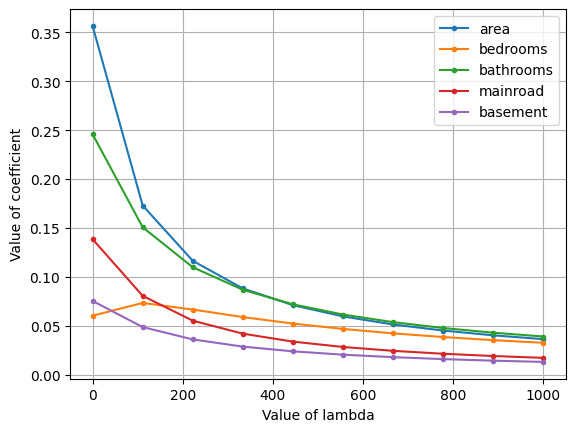

In [14]:
how_regularization_affects_Gauss(X, y, FEATURE_NAMES, np.linspace(0.01, 1000, 10));

In [15]:
def normal_pdf(x, mu, sigma):
    return np.exp(-0.5 * (x - mu)**2 / sigma**2) / np.sqrt(2 * np.pi) / sigma

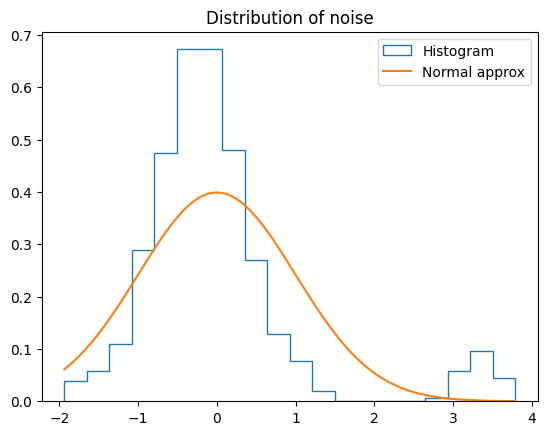

In [16]:
noise = RidgeGauss(100, FEATURE_NAMES).fit(X, y).noise_

possible_noises = np.linspace(noise.min(), noise.max(), 200)
plt.hist(noise, bins=20, histtype='step', density=True, label="Histogram")
plt.plot(possible_noises, normal_pdf(possible_noises, 0, 1), label="Normal approx")
plt.legend()
plt.title("Distribution of noise");